In [9]:
%reload_ext autoreload
%autoreload 2
    
from tqdm import tqdm

from pathlib import Path
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
import numpy as np

import tasks
import models

from rastermap import Rastermap

device = "cuda" if torch.cuda.is_available() else "cpu"

filepath = Path("~/Documents/Kempner/MCN2024/jobs/")
filepath = filepath.expanduser()

from analysis import load_perturbation, load_job, load_results, test_and_perturb, create_cdf_proportional_bins

In [2]:
# Hyperparameters
B = 300 # Batch size
D = 2 # Input dimensions
N = 50 # Number of recurrent neurons
learning_rate = 1e-2
num_epochs = 3600

start_sigma = 0.1
end_sigma = 0.5
sigma = torch.cat((
    start_sigma*torch.ones(num_epochs//3), 
    torch.linspace(start_sigma, end_sigma, num_epochs//3),
    end_sigma*torch.ones(num_epochs//3)
))

start_delay = 1
end_delay = 10
delay_time = torch.cat((
    start_delay * torch.ones(num_epochs//3, dtype=torch.int),
    torch.linspace(start_delay, end_delay, num_epochs//3, dtype=torch.int),
    end_delay*torch.ones(num_epochs//3, dtype=torch.int)
))
task = tasks.ContextualGoNogo(D, sigma, delay_time=10, num_contexts=2, task_type="privileged")

# Create network
net = models.GainRNN(task.input_dimensionality(), N, task.output_dimensionality(), input_rank=3, recurrent_rank=2)

loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

save_accuracy = torch.zeros(num_epochs)

# Training loop
for epoch in range(num_epochs):
    X, target, params = task.generate_data(B, sigma=sigma[epoch], delay_time=delay_time[epoch], source_strength=1.0, source_floor=0.5)

    optimizer.zero_grad()
    outputs, hidden = net(X, return_hidden=True)
    loss = loss_function(outputs, target)
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % (num_epochs // 10) == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [360/3600], Loss: 0.0482
Epoch [720/3600], Loss: 0.0106
Epoch [1080/3600], Loss: 0.0064


KeyboardInterrupt: 

In [19]:
# Load trained model and results

jobid = 33
model_index = 9
model, results, init_model = load_job(jobid, model_index=model_index, init=True)

args = results["args"]
task_params = results["task"]
train_loss = results["train_loss"]
train_accuracy = results["train_accuracy"]
train_evidence = results["train_evidence"]
train_fixation = results["train_fixation"]

task = tasks.ContextualGoNogo(
    args["input_dimensions"],
    args["end_sigma"],
    num_contexts=task_params["num_contexts"],
    stim_time=task_params["stim_time"],
    delay_time=args["end_delay"],
    decision_time=task_params["decision_time"],
    task_type=args["task_type"] if "task_type" in args else "embedded",
)
task.cursors = task_params["cursors"]

if args["network_type"] == "Gain":
    model_constructor = models.GainRNN
elif args["network_type"] == "Tau":
    model_constructor = models.TauRNN
elif args["network_type"] == "Full":
    model_constructor = models.FullRNN
else:
    raise ValueError("Unknown network type")

if args["network_type"] != "Full":
    kwargs = dict(input_rank=args["input_rank"], recurrent_rank=args["recurrent_rank"])
else:
    kwargs = {}

net = model_constructor(
    task.input_dimensionality(),
    args["num_neurons"],
    task.output_dimensionality(),
    **kwargs,
)

net.load_state_dict(model)

<All keys matched successfully>

In [20]:
X, target, params = task.generate_data(1000, sigma=0.1, source_floor=1.0)
output, hidden = net(X, return_hidden=True)
output = output.detach()

all_hidden = np.array(hidden.view(-1, hidden.size(2)).detach()).T

rm = Rastermap(n_PCs=100, n_clusters=20, locality=0.75, time_lag_window=1).fit(all_hidden, compute_X_embedding=False)
isort = rm.isort

2024-08-16 13:39:33,245 [INFO] normalizing data across axis=1
2024-08-16 13:39:33,728 [INFO] projecting out mean along axis=0
2024-08-16 13:39:33,993 [INFO] data normalized, 0.75sec
2024-08-16 13:39:33,994 [INFO] sorting activity: 512 valid samples by 80000 timepoints
2024-08-16 13:39:35,283 [INFO] n_PCs = 100 computed, 2.04sec
2024-08-16 13:39:35,351 [INFO] 20 clusters computed, time 2.11sec
2024-08-16 13:39:35,509 [INFO] clusters sorted, time 2.26sec
2024-08-16 13:39:35,537 [INFO] clusters upsampled, time 2.29sec


/usr/local/Caskroom/miniforge/base/envs/pointersequencer/lib/python3.11/site-packages/rastermap/cluster.py:138: UserWarning: found fewer than half the n_clusters that the user specified, rerunning with random initialization
  warnings.warn(


2024-08-16 13:39:35,655 [INFO] rastermap complete, time 2.41sec


In [25]:
ibatch = 0

task.decision_time = 200
X, target, params = task.generate_data(1, source_floor=0.0, source_strength=0.5)
output, hidden = net(X, return_hidden=True)
output = output.detach()

fig, ax = plt.subplots(4, 1, figsize=(12, 7), layout="constrained", sharex=True)
ax[0].imshow(X[ibatch].T, aspect="auto", cmap="bwr", interpolation="none", vmin=-1, vmax=1)
ax[0].set_title("Input")
# ax[1].plot(hidden[ibatch].detach().numpy()[:, isort], c='k', alpha=0.3)
ax[1].imshow(hidden[ibatch].detach().numpy().T[isort], aspect="auto", interpolation="none", cmap='gray')
ax[1].set_title("Hidden Activity")
ax[2].plot(output[ibatch].detach().numpy(), label="Output")
ax[2].set_title("Output")
ax[3].plot(target[ibatch].detach().numpy(), label="Target")
ax[3].set_title("Targets")
plt.show()

TypeError: ContextualGoNogo.generate_data() got an unexpected keyword argument 'decision_time'

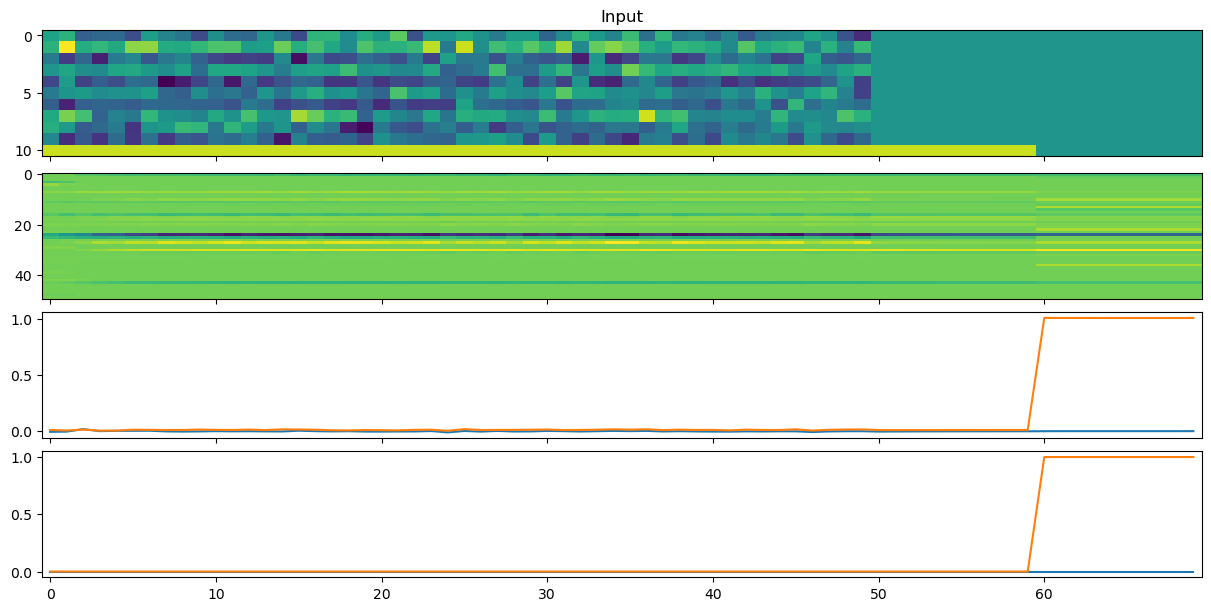

In [38]:
ibatch = 1

fig, ax = plt.subplots(4, 1, figsize=(12, 6), layout="constrained", sharex=True)
ax[0].imshow(X[ibatch].T, aspect="auto")
ax[0].set_title("Input")
ax[1].imshow(hidden[ibatch].detach().numpy().T, aspect="auto", interpolation="none")
ax[2].plot(outputs[ibatch].detach().numpy(), label="Output")
ax[3].plot(target[ibatch].detach().numpy(), label="Target")
plt.show()

In [6]:
params["s_empirical"][:10]

tensor([-0.0974,  0.0866, -0.0177,  0.0962, -0.0976, -0.0620, -0.0904,  0.0902,
         0.0977, -0.0929])

Beta: Parameter containing:
tensor(0.8745, requires_grad=True) Alpha: Parameter containing:
tensor([0.6411, 0.8757], requires_grad=True)
torch.Size([11, 2]) torch.Size([2, 2])


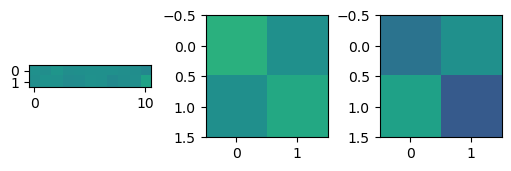

In [54]:
ipweight = net.input_weight.weight.detach().T
rcweight = net.recurrent_weight.weight.detach()
roweight = net.readout.weight.detach()
sd_score = roweight[0] - roweight[1]
isort = torch.argsort(sd_score)

print("Beta:", net.rnn.beta, "Alpha:", net.rnn.alpha)
print(ipweight.shape, rcweight.shape)

fig, ax = plt.subplots(1, 3, figsize=(5, 4), layout="constrained")
ax[0].imshow(ipweight.T[isort], vmin=-1, vmax=1)
ax[1].imshow(rcweight.T[isort][:, isort], vmin=-1, vmax=1)
ax[2].imshow(roweight.T[isort], vmin=-1, vmax=1)
plt.show()

In [44]:
ipweight.T

tensor([[-3.0019e-03,  8.0061e-03, -4.9607e-04, -7.6670e-03, -1.8169e-02,
          1.4057e-02, -5.0839e-03, -1.8974e-02,  3.1144e-03, -1.9640e-03,
          3.6878e-01],
        [ 9.8980e-04, -1.1440e-02, -8.7633e-04, -2.0143e-05, -2.5359e-03,
         -3.1783e-06, -3.8885e-02,  9.0732e-03, -1.1556e-05, -1.2034e-02,
          2.1957e-02]])

In [7]:
X, labels, params = task.generate_data(B)
outputs, spks, mems = net(X, start_integration=start_integration)
choice = torch.argmax(outputs, dim=1)

torch.cat((params["stimuli"][:10], labels[:10].unsqueeze(1), choice[:10].unsqueeze(1)), dim=1)

TypeError: ContextualGoNogo.generate_data() missing 1 required positional argument: 'T'

In [ ]:
ibatch = 8

print(X[ibatch].shape, spks[ibatch].shape, mems[ibatch].shape)

fig, ax = plt.subplots(3, 1, figsize=(9, 6), layout="constrained")
ax[0].imshow(X[ibatch].T, aspect="auto")
ax[1].imshow(spks[ibatch][:, isort].detach().T, aspect="auto")
ax[2].imshow(mems[ibatch][:, isort].detach().T, aspect="auto")
plt.show()